In [20]:
from langchain_community.tools import TavilySearchResults
from langchain.agents import tool, create_react_agent
from langchain_openai import ChatOpenAI
from langchain import hub
from dotenv import load_dotenv
import datetime

load_dotenv()


True

### Create the tools 

In [21]:
search_tool = TavilySearchResults(search_depth="basic")

@tool
def get_system_time(format:str = "%Y-%m-%d %H:%M:%S"):
    """ Return the current date and time in the specified format"""
    current_time = datetime.datetime.now()
    formatted_time  =current_time.strftime(format)
    return formatted_time

tools = [search_tool,get_system_time]

### Create the react agent runnable with create_react_agent function

In [22]:
llm = ChatOpenAI(model="gpt-4o")
react_prompt = hub.pull("hwchase17/react")

react_agent_runnable = create_react_agent(llm=llm, tools=tools, prompt=react_prompt)

D:\codes\ai\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### Define the State- The AgentState

In [23]:
from typing import TypedDict, Union, Annotated
from langchain_core.agents import AgentAction, AgentFinish
import operator 

class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentAction, None]
    intermediate_steps: Annotated[list[tuple[AgentAction,str]], operator.add]



### Create the Node functions 

In [24]:
# REASON NODE
def reason_node(state:AgentState)->AgentState:
    agent_outcome = react_agent_runnable.invoke(state)
    return {"agent_outcome": agent_outcome}


#ACT NODE
def act_node(state:AgentState)->AgentState:
    agent_action = state['agent_outcome']

    # extract tool name and input from action
    tool_name = agent_action.tool
    tool_input = agent_action.tool_input

    #find matching tool function
    tool_function = None
    for tool in tools:
        if tool.name ==tool_name:
            tool_function = tool 
            break

    #execute the tool with the input
    if tool_function:
        if isinstance(tool_function, dict):
            output = tool_function.invoke(**tool_input)
        else:
            output = tool_function.invoke(tool_input)
    else:
        output = f"Tool {tool_name} not found"
    
    return {"intermediate_steps":[(agent_action, str(output))]}

### Create the Graph that connects the nodes

In [25]:
from langgraph.graph import StateGraph, END

REASON_NODE="reason_node"
ACT_NODE="act_node"

def should_continue(state:AgentState)->str:
    if isinstance(state['agent_outcome'], AgentFinish):
        return "stop"
    return "action" 

flow = StateGraph(AgentState)

flow.add_node(REASON_NODE, reason_node)
flow.add_node(ACT_NODE, act_node)

flow.set_entry_point(REASON_NODE)
flow.add_conditional_edges(
    REASON_NODE,
    should_continue,
    {
        "stop": END,
        "action": ACT_NODE

    }
)
flow.add_edge(ACT_NODE,REASON_NODE)

app = flow.compile()

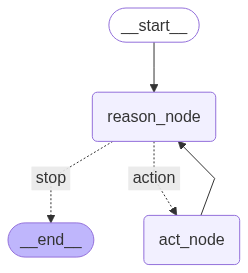

In [26]:
app

### Invoke the result

In [27]:
result= app.invoke({
    "input": "How many days ago was the latest SpaceX launch",
    "agent_outcome": None,
    "intermediate_steps": []
}) 


In [30]:
print(result)

{'input': 'How many days ago was the latest SpaceX launch', 'agent_outcome': AgentFinish(return_values={'output': 'The latest SpaceX launch occurred 21 days ago.'}, log='I now know the final answer. The latest SpaceX launch was on June 10, 2025, and today is July 1, 2025. Therefore, the latest SpaceX launch happened 21 days ago.\n\nFinal Answer: The latest SpaceX launch occurred 21 days ago.'), 'intermediate_steps': [(AgentAction(tool='tavily_search_results_json', tool_input='Latest SpaceX launch date', log="To determine how many days ago the latest SpaceX launch occurred, I need to find the date of the most recent launch. I will then compare that date to today's date to calculate the number of days that have passed since then.\nAction: tavily_search_results_json\nAction Input: Latest SpaceX launch date"), '[{\'title\': \'SpaceX Launch Schedule\', \'url\': \'https://rocketlaunch.org/launch-schedule/spacex\', \'content\': \'The most comprehensive, up-to-date list of upcoming SpaceX rock

In [34]:
result['agent_outcome'].return_values["output"]

'The latest SpaceX launch occurred 21 days ago.'